# Challenge Détection de Fraude - BNP Paribas Personal Finance
Solution complète pour la détection de fraude sur données de paniers d'achats 

Objectif: Maximiser la PR-AUC (> 0.14)

## Chargement et simulation des données

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [301]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [302]:
x_train = pd.read_csv("/kaggle/input/bnp-data-set/X_train_G3tdtEn.csv", low_memory=False)
y_train = pd.read_csv("/kaggle/input/bnp-data-set/Y_train_2_XPXJDyy.csv", low_memory=False)
x_test = pd.read_csv("/kaggle/input/bnp-data-set/X_test_8skS2ey.csv", low_memory=False)

# Vérifier les dimensions
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)

# Afficher les premières lignes
x_train.head()

x_train: (92790, 146)
y_train: (92790, 3)
x_test: (23198, 146)


,ID,item1,item2,item3,item4,item5,item6,item7,item8,item9,...,Nbr_of_prod_purchas16,Nbr_of_prod_purchas17,Nbr_of_prod_purchas18,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24,Nb_of_items
0,85517,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,51113,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,83008,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,78712,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,77846,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [303]:
# Types de colonnes
x_train.dtypes

# Valeurs manquantes
x_train.isnull().sum().sort_values(ascending=False)

# Distribution cible
y_train.value_counts(normalize=True)

index  ID      fraud_flag
0      85517   0             0.000011
61867  88741   0             0.000011
61865  17619   0             0.000011
61864  84077   0             0.000011
61863  81307   0             0.000011
                               ...   
30928  91735   0             0.000011
30927  101627  0             0.000011
30926  40491   0             0.000011
30925  75892   0             0.000011
92789  68268   0             0.000011
Name: proportion, Length: 92790, dtype: float64

## Analyse exploratoire - EDA

In [304]:
# Dimensions
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

# Types de colonnes
print(x_train.dtypes.value_counts())

# Valeurs manquantes
missing = x_train.isnull().sum().sort_values(ascending=False)
print("Colonnes avec le plus de valeurs manquantes :\n", missing.head(10))

x_train: (92790, 146)
y_train: (92790, 3)
object     96
float64    49
int64       1
Name: count, dtype: int64
Colonnes avec le plus de valeurs manquantes :
 make24                   92747
goods_code24             92747
cash_price24             92747
Nbr_of_prod_purchas24    92747
item24                   92747
model24                  92747
make23                   92741
model23                  92741
Nbr_of_prod_purchas23    92740
cash_price23             92740
dtype: int64


In [305]:
# fusion des données X et Y pour l'EDA
train_df = pd.concat([x_train, y_train], axis=1)
train_df.head()


,ID,item1,item2,item3,item4,item5,item6,item7,item8,item9,...,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24,Nb_of_items,index,ID,fraud_flag
0,85517,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,85517,0
1,51113,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,51113,0
2,83008,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,83008,0
3,78712,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3,78712,0
4,77846,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4,77846,0


In [306]:
# taux de fraude global 
fraud_rate = train_df['fraud_flag'].mean()
print(f"Taux de fraude global : {fraud_rate:.3%}")

Taux de fraude global : 1.421%


Les classes sont effectivement très déséquilibrées.

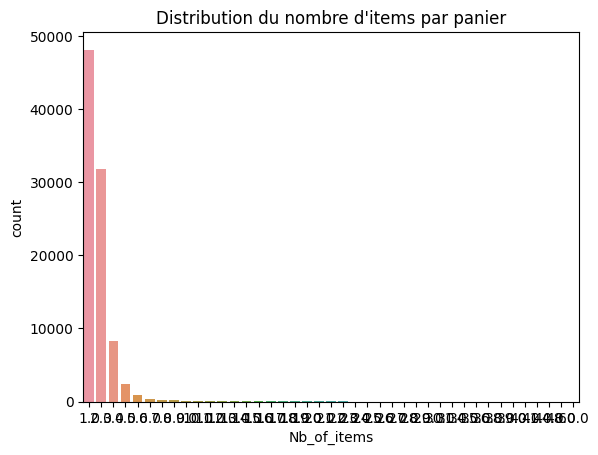

             count  sum      mean
Nb_of_items                      
1.0          48134  611  0.012694
2.0          31755  594  0.018706
3.0           8339   81  0.009713
4.0           2392   12  0.005017
5.0            834    6  0.007194
6.0            390    5  0.012821
7.0            219    0  0.000000
8.0            159    1  0.006289
9.0             96    0  0.000000
10.0            88    0  0.000000
11.0            62    1  0.016129
12.0            65    0  0.000000
13.0            38    0  0.000000
14.0            26    2  0.076923
15.0            28    0  0.000000
16.0            23    1  0.043478
17.0            22    0  0.000000
18.0            17    0  0.000000
19.0            12    2  0.166667
20.0            14    1  0.071429
21.0            14    0  0.000000
22.0            13    1  0.076923
23.0             7    0  0.000000
24.0             5    1  0.200000
25.0             1    0  0.000000
26.0             4    0  0.000000
27.0             1    0  0.000000
28.0          

In [307]:
# analyse du nombre d'items par panier
sns.countplot(x='Nb_of_items', data=train_df)
plt.title("Distribution du nombre d'items par panier")
plt.show()

# Taux de fraude par nombre d'items
fraud_by_items = train_df.groupby('Nb_of_items')['fraud_flag'].agg(['count', 'sum', 'mean'])
print(fraud_by_items)

La majorité des paniers contiennent 1 ou 2 items, ce qui est cohérent avec des achats individuels ou petits paniers.

Les paniers avec 2 items ont un taux de fraude 1,87%, légèrement supérieur à la moyenne globale (~1,4%).

Les paniers avec 1 item ont un taux de fraude plus faible 1,27%.

Les paniers très grands ou extrêmes (14, 19, 24 items…) ont des taux de fraude très élevés (jusqu’à 20%), mais ces paniers sont rares, donc attention à l’échantillonnage.

In [308]:
# prix total par panier 

# Colonnes prix et quantités
price_cols = [f'cash_price{i}' for i in range(1, 25)]
qty_cols = [f'Nbr_of_prod_purchas{i}' for i in range(1, 25)]

train_df['total_basket_price'] = sum(train_df[p]*train_df[q] for p,q in zip(price_cols, qty_cols))

# Moyennes
print("Prix moyen panier frauduleux:", train_df[train_df['fraud_flag']==1]['total_basket_price'].mean())
print("Prix moyen panier normal:", train_df[train_df['fraud_flag']==0]['total_basket_price'].mean())

Prix moyen panier frauduleux: 2238.0
Prix moyen panier normal: 3385.3809523809523


Pour chaque panier, on multiplie le prix de chaque item par sa quantité et on fait la somme sur tous les items, ce qui donne la valeur totale du panier. C’est une feature très pertinente pour détecter la fraude, car les fraudeurs peuvent acheter des paniers plus chers ou plus volumineux.

Ici, les paniers normaux ont un prix moyen plus élevé que les paniers frauduleux. Les fraudes sont souvent moins fréquentes et peuvent concerner des petits paniers électroniques spécifiques.

In [309]:
# analyse des catégories et marques

# Items les plus fréquents
item_counts = pd.Series([train_df[f'item{i}'] for i in range(1, 25)]).value_counts()
print("Top items:\n", item_counts.head(10))

# Makes les plus fréquents (marques les plus fréquentes)
make_counts = pd.Series([train_df[f'make{i}'] for i in range(1, 25)]).value_counts()
print("Top makes:\n", make_counts.head(10))

Top items:
 0                               COMPUTERS
1        COMPUTER PERIPHERALS ACCESSORIES
2                 TELEVISIONS HOME CINEMA
3                               COMPUTERS
4                 TELEVISIONS HOME CINEMA
                       ...               
92785    COMPUTER PERIPHERALS ACCESSORIES
92786                           COMPUTERS
92787                   BEDROOM FURNITURE
92788                           COMPUTERS
92789             TELEVISIONS HOME CINEMA
Name: item1, Length: 92790, dtype: object    1
0                                     NaN
1                                     NaN
2                                     NaN
3        COMPUTER PERIPHERALS ACCESSORIES
4                                     NaN
                       ...               
92785                   FULFILMENT CHARGE
92786                                 NaN
92787                   BEDROOM FURNITURE
92788                           COMPUTERS
92789                                 NaN
Name: item2, Leng

L'idée est de savoir quels produits et marques apparaissent le plus souvent. Permet d'identifier des patterns potentiels de fraude (ex : certaines catégories ou marques plus ciblées).

Top items : COMPUTERS, TELEVISIONS HOME CINEMA, COMPUTER PERIPHERALS ACCESSORIES

Top makes : APPLE, SAMSUNG, SONY, LG

In [310]:
# visualisation des patterns suspects pour l'électronique 
electronics = ['Computer', 'Phone', 'TV']
train_df['has_electronics'] = 0

for i in range(1, 25):
    if f'item{i}' in train_df.columns:
        train_df['has_electronics'] |= train_df[f'item{i}'].isin(electronics).astype(int)
train_df.groupby('has_electronics')['fraud_flag'].mean()

has_electronics
0    0.014215
Name: fraud_flag, dtype: float64

On vérifie si la présence d’articles électroniques dans le panier est un indicateur de fraude.

Même si l’électronique est la catégorie la plus vendue, le taux de fraude y est faible, cela signifie que la majorité des fraudes ne concerne pas l’électronique.

#### Conclusion : 
Le taux global de fraude est faible (~1,4 %), ce qui rend le dataset très déséquilibré.
Les fraudes concernent surtout des paniers atypiques ou très grands, pas forcément les plus chers.
La valeur totale du panier et la taille du panier sont des features clés pour détecter la fraude.
Les produits électroniques sont les plus vendus, mais ont un taux de fraude faible.
Certaines colonnes ont beaucoup de valeurs manquantes et devront être traitées avant le modeling.

## Feature engineering
Consiste à transformer et créer des variables plus pertinentes pour le modèle

In [311]:
# calcul des features de base sur le panier

# Colonnes prix et quantités
price_cols = [f'cash_price{i}' for i in range(1, 25)]
qty_cols = [f'Nbr_of_prod_purchas{i}' for i in range(1, 25)]

# Initialisation des colonnes
train_df['total_basket_price'] = 0
train_df['total_products'] = 0
train_df['avg_item_price'] = 0

# Calcul du prix total et nombre de produits
for p, q in zip(price_cols, qty_cols):
    train_df['total_basket_price'] += train_df[p].fillna(0) * train_df[q].fillna(0)
    train_df['total_products'] += train_df[q].fillna(0)

# Prix moyen par item (éviter division par zéro)
train_df['avg_item_price'] = train_df['total_basket_price'] / train_df['Nb_of_items'].replace(0, 1)

On résume chaque panier avec le prix total, le nombre total de produits, et le prix moyen par item.

In [312]:
# diversité des catégories et des marques

# Initialisation
train_df['unique_categories'] = 0
train_df['unique_makes'] = 0

category_cols = [f'item{i}' for i in range(1, 25)]
make_cols = [f'make{i}' for i in range(1, 25)]

train_df['unique_categories'] = train_df[category_cols].nunique(axis=1)
train_df['unique_makes'] = train_df[make_cols].nunique(axis=1)

On mesure combien de catégories et marques différentes sont présentes dans chaque panier.

In [313]:
# features pour l'électronique

electronics = ['Computer', 'Phone', 'TV']

# Présence d’au moins un produit électronique
train_df['has_electronics'] = 0
train_df['electronics_count'] = 0
train_df['electronics_price'] = 0

for i in range(1, 25):
    is_elec = train_df[f'item{i}'].isin(electronics).astype(int)
    train_df['has_electronics'] |= is_elec
    train_df['electronics_count'] += is_elec * train_df[f'Nbr_of_prod_purchas{i}'].fillna(0)
    train_df['electronics_price'] += is_elec * train_df[f'cash_price{i}'].fillna(0) * train_df[f'Nbr_of_prod_purchas{i}'].fillna(0)


Indique si le panier contient de l’électronique, combien d’articles électroniques, et leur prix total.

In [314]:
# ratios et indicateurs supplémentaires

train_df['avg_qty_per_item'] = train_df['total_products'] / train_df['Nb_of_items'].replace(0, 1)
train_df['price_per_product'] = train_df['total_basket_price'] / train_df['total_products'].replace(0, 1)
train_df['make_diversity_ratio'] = train_df['unique_makes'] / train_df['Nb_of_items'].replace(0, 1)
train_df['category_diversity_ratio'] = train_df['unique_categories'] / train_df['Nb_of_items'].replace(0, 1)

In [315]:
# stats sur les prix
train_df['max_item_price'] = train_df[price_cols].max(axis=1)
train_df['min_item_price'] = train_df[price_cols].min(axis=1)
train_df['std_item_price'] = train_df[price_cols].std(axis=1)
train_df['skew_item_price'] = train_df[price_cols].skew(axis=1)  # asymétrie de la distribution

In [316]:
#ratios de concentration
train_df['max_price_ratio'] = train_df['max_item_price'] / train_df['total_basket_price'].replace(0, 1)
train_df['electronics_ratio'] = train_df['electronics_price'] / train_df['total_basket_price'].replace(0, 1)

In [317]:
#flags
train_df['make_diversity_per_product'] = train_df['unique_makes'] / train_df['total_products'].replace(0, 1)
train_df['category_diversity_per_product'] = train_df['unique_categories'] / train_df['total_products'].replace(0, 1)

In [318]:
train_df['is_expensive_basket'] = (train_df['total_basket_price'] > 5000).astype(int)
train_df['is_large_basket'] = (train_df['Nb_of_items'] > 10).astype(int)
train_df['is_single_brand'] = (train_df['unique_makes'] == 1).astype(int)

In [319]:
# --- 20 nouvelles features pour enrichir le dataset ---

# 1. Panier très grand ? (> 5 items)
train_df['large_basket_flag'] = (train_df['Nb_of_items'] > 5).astype(int)

# 2. Panier moyen ? (2-5 items)
train_df['medium_basket_flag'] = ((train_df['Nb_of_items'] > 1) & (train_df['Nb_of_items'] <= 5)).astype(int)

# 3. Prix moyen d'un produit électronique
train_df['avg_electronics_price'] = train_df['electronics_price'] / train_df['electronics_count'].replace(0,1)

# 4. Ratio produits électroniques / total produits
train_df['elec_ratio'] = train_df['electronics_count'] / train_df['total_products'].replace(0,1)

# 5. Ratio marques uniques / total produits
train_df['make_ratio'] = train_df['unique_makes'] / train_df['total_products'].replace(0,1)

# 6. Ratio catégories uniques / total produits
train_df['category_ratio'] = train_df['unique_categories'] / train_df['total_products'].replace(0,1)

# 7. Max price parmi les items du panier
price_cols = [f'cash_price{i}' for i in range(1, 25)]
train_df['max_item_price'] = train_df[price_cols].max(axis=1)

# 8. Min price parmi les items du panier
train_df['min_item_price'] = train_df[price_cols].min(axis=1)

# 9. Écart-type des prix des items
train_df['std_item_price'] = train_df[price_cols].std(axis=1)

# 10. Nombre d'items différents (non nuls)
train_df['num_items_nonnull'] = train_df[price_cols].notnull().sum(axis=1)

# 11. Panier très cher ? (> 90 percentile)
price_thresh = train_df['total_basket_price'].quantile(0.9)
train_df['expensive_basket_flag'] = (train_df['total_basket_price'] > price_thresh).astype(int)

# 12. Moyenne des quantités par item
qty_cols = [f'Nbr_of_prod_purchas{i}' for i in range(1, 25)]
train_df['avg_qty'] = train_df[qty_cols].replace(np.nan, 0).mean(axis=1)

# 13. Quantité max par item
train_df['max_qty'] = train_df[qty_cols].replace(np.nan, 0).max(axis=1)

# 14. Quantité min par item
train_df['min_qty'] = train_df[qty_cols].replace(np.nan, 0).min(axis=1)

# 15. Écart-type des quantités
train_df['std_qty'] = train_df[qty_cols].replace(np.nan, 0).std(axis=1)

# 16. Nombre de marques uniques parmi les 3 premiers items
train_df['top3_unique_makes'] = train_df[[f'make{i}' for i in range(1,4)]].nunique(axis=1)

# 17. Nombre de catégories uniques parmi les 3 premiers items
train_df['top3_unique_categories'] = train_df[[f'item{i}' for i in range(1,4)]].nunique(axis=1)

# 18. Ratio marques top3 / total marques
train_df['top3_make_ratio'] = train_df['top3_unique_makes'] / train_df['unique_makes'].replace(0,1)

# 19. Ratio catégories top3 / total catégories
train_df['top3_category_ratio'] = train_df['top3_unique_categories'] / train_df['unique_categories'].replace(0,1)

# 20. Flag si panier avec au moins 2 produits Apple
apple_count = sum([(train_df[f'make{i}']=='APPLE').astype(int) for i in range(1,25)])
train_df['apple_flag'] = (apple_count >= 2).astype(int)

In [320]:
# encodage des variables catégorielles fréquentes

# On prend les 5 items et marques les plus fréquents sur les 3 premiers items
categorical_features = []

for i in range(1, 4):
    item_col = f'item{i}'
    make_col = f'make{i}'
    
    if item_col in train_df.columns:
        top_items = train_df[item_col].value_counts().head(5).index
        for item in top_items:
            train_df[f'has_{item.lower().replace(" ", "_")}_item{i}'] = (train_df[item_col] == item).astype(int)
            categorical_features.append(f'has_{item.lower().replace(" ", "_")}_item{i}')
        
        top_makes = train_df[make_col].value_counts().head(5).index
        for make in top_makes:
            train_df[f'has_{make.lower().replace(" ", "_")}_make{i}'] = (train_df[make_col] == make).astype(int)
            categorical_features.append(f'has_{make.lower().replace(" ", "_")}_make{i}')

Transforme les items/marques les plus fréquents en features binaires, prêtes pour le modèle.

## Préparation finale des features

Consiste à transformer le data set issu du feature engineering en matrices prêtes pour les modèles

In [321]:
#sélection des colonnes : on prend toutes les colonnes créées dans le FE

feature_cols = [
    'total_basket_price', 'total_products', 'avg_item_price',
    'has_electronics', 'electronics_count', 'electronics_price',
    'unique_makes', 'unique_categories',
    'avg_qty_per_item', 'price_per_product',
    'make_diversity_ratio', 'category_diversity_ratio',
    'max_item_price', 'min_item_price', 'std_item_price',
    'max_price_ratio', 'electronics_ratio',
    'is_expensive_basket', 'is_large_basket', 'is_single_brand',
    'Nb_of_items'
]

# Vérifier que toutes les features existent
available_features = [col for col in feature_cols if col in train_df.columns]
print(f"Features disponibles: {available_features}")

# Préparer X et y de manière cohérente
X = train_df[available_features].fillna(0)
y = train_df['fraud_flag']

print(f"Taille X: {X.shape}")
print(f"Taille y: {y.shape}")

Features disponibles: ['total_basket_price', 'total_products', 'avg_item_price', 'has_electronics', 'electronics_count', 'electronics_price', 'unique_makes', 'unique_categories', 'avg_qty_per_item', 'price_per_product', 'make_diversity_ratio', 'category_diversity_ratio', 'max_item_price', 'min_item_price', 'std_item_price', 'max_price_ratio', 'electronics_ratio', 'is_expensive_basket', 'is_large_basket', 'is_single_brand', 'Nb_of_items']
Taille X: (92790, 21)
Taille y: (92790,)


In [322]:
# on normalise les features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # pour l'entraînement

In [323]:
# séparation des features et label pour l’entraînement et l’évaluation

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Entrainement des modèles

## Choix des modèles : 

On combine plusieurs modèles pour couvrir différents points forts
1. XGBoost
2. Random Forest
3. Logistic Regression avec scaling

Les fraudes sont rares (~1,4%), donc un seul modèle peut manquer certains patterns. Les modèles boostés captent les relations complexes, RF les tendances générales, et LR permet de vérifier les effets linéaires. Ensuite, on fait un ensemble pour combiner les forces de chaque modèle.

## Préparation avant entrainement

In [324]:
# import des bibliothèques
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import average_precision_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

In [325]:
# calcul du poids des classes, utile pour compenser le déséquilibre (fraudes rares)
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Poids de classe :", weight_dict)

Poids de classe : {0: 0.5072099353893583, 1: 35.17437452615618}


## Définition des modèles

In [326]:
models = {
    "XGBoost": xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        scale_pos_weight=class_weights[1]/class_weights[0],
        random_state=42,
        use_label_encoder=False
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        solver='liblinear'
    ),
    "LightGBM": lgb.LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=weight_dict[0]/weight_dict[1],
        random_state=42,
        n_jobs=-1
    )
}


## Entrainement et validation croisée

In [327]:
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nEntraînement {name}...")
    
    # Choisir les bonnes données selon le modèle
    if name == "Logistic Regression":
        X_use = X_scaled  # Données standardisées pour LR
    else:
        X_use = X.values  # Données originales pour XGB et RF
    
    # Vérification des tailles
    print(f"  Taille X_use: {X_use.shape}")
    print(f"  Taille y: {y.shape}")
    
    # Cross-validation PR-AUC
    cv_scores = cross_val_score(
        model, X_use, y, cv=cv, scoring='average_precision'
    )
    results[name] = cv_scores
    print(f"   PR-AUC CV: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    # Entraînement final sur toutes les données
    model.fit(X_use, y)
    models[name] = model


Entraînement XGBoost...
  Taille X_use: (92790, 21)
  Taille y: (92790,)
   PR-AUC CV: 0.1329 (+/- 0.0233)

Entraînement Random Forest...
  Taille X_use: (92790, 21)
  Taille y: (92790,)
   PR-AUC CV: 0.0957 (+/- 0.0293)

Entraînement Logistic Regression...
  Taille X_use: (92790, 21)
  Taille y: (92790,)
   PR-AUC CV: 0.0258 (+/- 0.0046)

Entraînement LightGBM...
  Taille X_use: (92790, 21)
  Taille y: (92790,)
[LightGBM] [Info] Number of positive: 1056, number of negative: 73176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2129
[LightGBM] [Info] Number of data points in the train set: 74232, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014226 -> initscore=-4.238379
[LightGBM] [Info] Start training from score -4.238379
[LightGBM] [Info] Number o

In [328]:
print("\n Résultats CV PR-AUC :")
for name, scores in results.items():
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")


 Résultats CV PR-AUC :
XGBoost: 0.1329 (+/- 0.0233)
Random Forest: 0.0957 (+/- 0.0293)
Logistic Regression: 0.0258 (+/- 0.0046)
LightGBM: 0.1357 (+/- 0.0137)


## Prédiction et assemblage

## FE identique pour le fichier test

In [329]:
test_df = x_test.copy()

print("Début du Feature Engineering sur le fichier test...")
print(f"Taille initiale test_df: {test_df.shape}")

# Colonnes prix et quantités
price_cols = [f'cash_price{i}' for i in range(1, 25)]
qty_cols = [f'Nbr_of_prod_purchas{i}' for i in range(1, 25)]

# 1. Features de base sur le panier
print("Calcul des features de base...")

# Initialisation des colonnes
test_df['total_basket_price'] = 0
test_df['total_products'] = 0
test_df['avg_item_price'] = 0

# Calcul du prix total et nombre de produits
for p, q in zip(price_cols, qty_cols):
    test_df['total_basket_price'] += test_df[p].fillna(0) * test_df[q].fillna(0)
    test_df['total_products'] += test_df[q].fillna(0)

# Prix moyen par item (éviter division par zéro)
test_df['avg_item_price'] = test_df['total_basket_price'] / test_df['Nb_of_items'].replace(0, 1)

# 2. Diversité des catégories et des marques
print("Calcul de la diversité...")

category_cols = [f'item{i}' for i in range(1, 25)]
make_cols = [f'make{i}' for i in range(1, 25)]

test_df['unique_categories'] = test_df[category_cols].nunique(axis=1)
test_df['unique_makes'] = test_df[make_cols].nunique(axis=1)

# 3. Features pour l'électronique
print("Calcul des features électronique...")

electronics = ['Computer', 'Phone', 'TV']

# Présence d'au moins un produit électronique
test_df['has_electronics'] = 0
test_df['electronics_count'] = 0
test_df['electronics_price'] = 0

for i in range(1, 25):
    is_elec = test_df[f'item{i}'].isin(electronics).astype(int)
    test_df['has_electronics'] |= is_elec
    test_df['electronics_count'] += is_elec * test_df[f'Nbr_of_prod_purchas{i}'].fillna(0)
    test_df['electronics_price'] += is_elec * test_df[f'cash_price{i}'].fillna(0) * test_df[f'Nbr_of_prod_purchas{i}'].fillna(0)

# 4. Ratios et indicateurs supplémentaires
print("Calcul des ratios...")

test_df['avg_qty_per_item'] = test_df['total_products'] / test_df['Nb_of_items'].replace(0, 1)
test_df['price_per_product'] = test_df['total_basket_price'] / test_df['total_products'].replace(0, 1)
test_df['make_diversity_ratio'] = test_df['unique_makes'] / test_df['Nb_of_items'].replace(0, 1)
test_df['category_diversity_ratio'] = test_df['unique_categories'] / test_df['Nb_of_items'].replace(0, 1)

# Stats sur les prix
test_df['max_item_price'] = test_df[price_cols].max(axis=1)
test_df['min_item_price'] = test_df[price_cols].min(axis=1)
test_df['std_item_price'] = test_df[price_cols].std(axis=1)
test_df['skew_item_price'] = test_df[price_cols].skew(axis=1)

# Ratios de concentration
test_df['max_price_ratio'] = test_df['max_item_price'] / test_df['total_basket_price'].replace(0, 1)
test_df['electronics_ratio'] = test_df['electronics_price'] / test_df['total_basket_price'].replace(0, 1)

# Flags
test_df['make_diversity_per_product'] = test_df['unique_makes'] / test_df['total_products'].replace(0, 1)
test_df['category_diversity_per_product'] = test_df['unique_categories'] / test_df['total_products'].replace(0, 1)

test_df['is_expensive_basket'] = (test_df['total_basket_price'] > 5000).astype(int)
test_df['is_large_basket'] = (test_df['Nb_of_items'] > 10).astype(int)
test_df['is_single_brand'] = (test_df['unique_makes'] == 1).astype(int)

# 5. 20 nouvelles features supplémentaires
print("Calcul des 20 features supplémentaires...")

# 1. Panier très grand ? (> 5 items)
test_df['large_basket_flag'] = (test_df['Nb_of_items'] > 5).astype(int)

# 2. Panier moyen ? (2-5 items)
test_df['medium_basket_flag'] = ((test_df['Nb_of_items'] > 1) & (test_df['Nb_of_items'] <= 5)).astype(int)

# 3. Prix moyen d'un produit électronique
test_df['avg_electronics_price'] = test_df['electronics_price'] / test_df['electronics_count'].replace(0,1)

# 4. Ratio produits électroniques / total produits
test_df['elec_ratio'] = test_df['electronics_count'] / test_df['total_products'].replace(0,1)

# 5. Ratio marques uniques / total produits
test_df['make_ratio'] = test_df['unique_makes'] / test_df['total_products'].replace(0,1)

# 6. Ratio catégories uniques / total produits
test_df['category_ratio'] = test_df['unique_categories'] / test_df['total_products'].replace(0,1)

# 7-8. Max et Min price déjà calculés plus haut

# 9-10. Écart-type et nombre d'items non nuls
test_df['num_items_nonnull'] = test_df[price_cols].notnull().sum(axis=1)

# 11. Panier très cher ? (utiliser le même seuil que le train - à calculer depuis train_df)
# ATTENTION: il faut utiliser le même seuil que le train !
# Si tu as accès à train_df, utilise: price_thresh = train_df['total_basket_price'].quantile(0.9)
# Sinon, on peut estimer ou utiliser une valeur fixe
price_thresh = 5000  # À ajuster selon ton train_df
test_df['expensive_basket_flag'] = (test_df['total_basket_price'] > price_thresh).astype(int)

# 12-15. Stats sur les quantités
test_df['avg_qty'] = test_df[qty_cols].replace(np.nan, 0).mean(axis=1)
test_df['max_qty'] = test_df[qty_cols].replace(np.nan, 0).max(axis=1)
test_df['min_qty'] = test_df[qty_cols].replace(np.nan, 0).min(axis=1)
test_df['std_qty'] = test_df[qty_cols].replace(np.nan, 0).std(axis=1)

# 16-17. Top 3 items
test_df['top3_unique_makes'] = test_df[[f'make{i}' for i in range(1,4)]].nunique(axis=1)
test_df['top3_unique_categories'] = test_df[[f'item{i}' for i in range(1,4)]].nunique(axis=1)

# 18-19. Ratios top3
test_df['top3_make_ratio'] = test_df['top3_unique_makes'] / test_df['unique_makes'].replace(0,1)
test_df['top3_category_ratio'] = test_df['top3_unique_categories'] / test_df['unique_categories'].replace(0,1)

# 20. Flag Apple
apple_count = sum([(test_df[f'make{i}']=='APPLE').astype(int) for i in range(1,25)])
test_df['apple_flag'] = (apple_count >= 2).astype(int)

# 6. Encodage des variables catégorielles (optionnel - à synchroniser avec le train)
print("Encodage catégoriel...")
categorical_features = []

for i in range(1, 4):
    item_col = f'item{i}'
    make_col = f'make{i}'

    if item_col in test_df.columns:
        common_items = ['COMPUTERS', 'TELEVISIONS HOME CINEMA', 'COMPUTER PERIPHERALS ACCESSORIES', 'PHONES', 'TABLETS']
        common_makes = ['APPLE', 'SAMSUNG', 'SONY', 'LG', 'HP']
        
        for item in common_items:
            test_df[f'has_{item.lower().replace(" ", "_")}_item{i}'] = (test_df[item_col] == item).astype(int)
            categorical_features.append(f'has_{item.lower().replace(" ", "_")}_item{i}')

        for make in common_makes:
            test_df[f'has_{make.lower().replace(" ", "_")}_make{i}'] = (test_df[make_col] == make).astype(int)
            categorical_features.append(f'has_{make.lower().replace(" ", "_")}_make{i}')

# 7. Sélection finale des features (identiques au train)
print("Sélection finale des features...")

# IMPORTANT: Utilise exactement les mêmes features que dans available_features du train
feature_cols = [
    'total_basket_price', 'total_products', 'avg_item_price',
    'has_electronics', 'electronics_count', 'electronics_price',
    'unique_makes', 'unique_categories',
    'avg_qty_per_item', 'price_per_product',
    'make_diversity_ratio', 'category_diversity_ratio',
    'max_item_price', 'min_item_price', 'std_item_price',
    'max_price_ratio', 'electronics_ratio',
    'is_expensive_basket', 'is_large_basket', 'is_single_brand',
    'Nb_of_items'
]

# Vérifier que toutes les features existent dans le test
available_features_test = [col for col in feature_cols if col in test_df.columns]
missing_features = [col for col in feature_cols if col not in test_df.columns]

print(f"Features disponibles dans test: {len(available_features_test)}")
print(f"Features manquantes: {missing_features}")

# Préparer X_test final
X_test = test_df[available_features_test].fillna(0)
print(f"Taille finale X_test: {X_test.shape}")

# 8. Normalisation (utiliser le même scaler que le train !)
# ATTENTION: Tu dois utiliser le scaler déjà entraîné sur le train, pas en créer un nouveau !
X_test_scaled = scaler.transform(X_test)  # utilise le scaler du train

print("Feature Engineering terminé pour le fichier test !")
print(f"Prêt pour les prédictions avec X_test de taille: {X_test.shape}")

Début du Feature Engineering sur le fichier test...
Taille initiale test_df: (23198, 146)
Calcul des features de base...
Calcul de la diversité...
Calcul des features électronique...
Calcul des ratios...
Calcul des 20 features supplémentaires...
Encodage catégoriel...
Sélection finale des features...
Features disponibles dans test: 21
Features manquantes: []
Taille finale X_test: (23198, 21)
Feature Engineering terminé pour le fichier test !
Prêt pour les prédictions avec X_test de taille: (23198, 21)


## Création de la soumission

In [332]:
print("\nGénération des prédictions...")

lgb_preds = models["LightGBM"].predict_proba(X_test)[:, 1]

id_column = 'ID' if 'ID' in test_df.columns else test_df.columns[0]

submission = pd.DataFrame({
    "ID": test_df[id_column],
    "fraud_flag": lgb_preds
})

submission.to_csv("submission.csv", index=True)
print("Fichier de soumission créé : submission.csv")
print(f"Nombre de prédictions: {len(submission)}")
print(f"Taux de fraude prédit: {lgb_preds.mean():.4%}")
print(submission.head(10))


Génération des prédictions...
Fichier de soumission créé : submission.csv
Nombre de prédictions: 23198
Taux de fraude prédit: 0.0906%
      ID  fraud_flag
0  64707    0.000032
1  63919    0.000002
2  15664    0.000010
3   6626    0.001200
4  26766    0.000878
5   2055    0.000168
6  80703    0.000008
7  45482    0.011287
8  91264    0.000032
9   1049    0.000002
